In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')#设置绘图风格
import random
import warnings
warnings.filterwarnings('ignore')

# 公用变量
hour_str=['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

In [2]:
##########################  公用函数    ################

# 将站点名称统一转为str
def st_id2_str(df,col):
    str_st,index_i = [],[]
    for i in df.index:
        if '.' not in str(df[col][i]):
            pass
        elif len(str(df[col][i])) == 6:
            str_st.append(str(df[col][i])+'0s')
            index_i.append(i)
        elif len(str(df[col][i])) == 7:
            str_st.append(str(df[col][i])+'s')
            index_i.append(i)
        else:
            pass
    df = df[(df.index).isin(index_i)]
    df[col] = str_st
    return df

# 获取当日活动站点状态信息
def get_status(status_df,sta_loc4):
    N_O_name = pd.read_csv('C:/Users/83621/citibike1/new_old_name.csv',index_col = 0)
    N_O_name = st_id2_str(N_O_name,'short_name') # 转换站点id数据格式
    N_O_name = N_O_name[(N_O_name['legacy_id']).isin(list(status_df['station_id']))]#与状态数据交叠
    N_O_name = N_O_name[(N_O_name['short_name']).isin(list(sta_loc4['station_id']))]#与当天活动站点的交叠
    N_O_name.columns = ['station_id','name2']
    temp = pd.merge(N_O_name,status_df,on='station_id')#与状态数据合并
    temp = temp[['name2','num_docks_available','num_bikes_available']]
    temp.columns = ['station_id','docks_available','bikes_available']
    return temp

In [3]:
#####   数据准备
today = '2022-01-25'
N = pd.read_csv("C:/Users/83621/citibike1/ori_data/"+today[0:4]+today[5:7]+"-citibike-tripdata.csv",index_col=0)
N = N[N.index.isin( [x for x in N.index if (N['started_at'][x])[0:10]==today])]
N = st_id2_str(N,'start_station_id')
N = st_id2_str(N,'end_station_id')# 站点名称格式规范化
status_df = pd.read_csv("D:/bike/2022-01-25-10-43-57.csv",index_col=0)#2022-01-24-08-56-34
status_df = status_df[status_df['capacity']!=0]#舍去无效站点
sample0 = pd.read_csv("C:/Users/83621/citibike1/sample_SET.csv",index_col=0)
sta_loc4 = sample0[sample0['date']==today][['station_id','lat','lon']]#站点坐标数据
sta_loc4.index = range(len(sta_loc4))
status_df = get_status(status_df,sta_loc4)
#容量和现有量 Status_df
status_df['Capcity'] = status_df['docks_available']+status_df['bikes_available']
status_df.index = range(len(status_df))
sta_loc4 = sta_loc4[(sta_loc4['station_id']).isin(list(status_df['station_id']))]
del status_df['docks_available']

In [4]:
#================= 假使初始库存下满意度，对应函数F（x）  =====================================

##### 0.  获取各个站点借、还车需求量-----------------------------------------------------------------------
def X_b_r(hour,status_df,N):
    demand_b, demand_r = [],[]
    for st_id in status_df['station_id']:
        temp_N = N[N['start_station_id']==st_id]
        demand_b.append(len([1 for x in temp_N.index if temp_N['started_at'][x][11:13]==hour_str[hour]]))
        temp_N = N[N['end_station_id']==st_id]
        demand_r.append(len([1 for x in temp_N.index if temp_N['ended_at'][x][11:13]==hour_str[hour]]))
    return demand_b,demand_r
###### 1. 获取各个 xk概率，和 初始量-期望损失 关系------------------------------------------------------------
def expect_thwarted_df(C,borrow_num,return_num):
    N = 1000  #蒙特卡洛次数
    xk = []
    MC_borrow = np.random.poisson(lam = borrow_num, size = N)#泊松分布 借车需求
    MC_return = np.random.poisson(lam = return_num, size = N)#泊松分布 还车需求
    xk = [MC_borrow[x]-MC_return[x] for x in range(N)]#净借量
    xk_s = pd.Series(xk)
    
    Pro = {}#xk为各个值时的概率
    for i in set(xk):
        Pro[i] = sum(xk_s == i)/N   

    invo_expect_thwarted = pd.DataFrame(columns = ['cs_invo','thwarted_rent','thwarted_return','thwarted_ratio'])
    for j in range(0,C+1):
        temp1,temp2 = 0,0
        for k in set(xk_s[xk_s > j]):#单车供不应求，最终站点库存为0
            temp1 += Pro[k] * (k-j)
        for k in set(xk_s[xk_s < j-C]):#单车供过求，最终站点库存满C
            temp2 += Pro[k] * (j-C-k)
        temp3 = (len(xk_s[xk_s > j])+len(xk_s[xk_s < j-C]))/N
        invo_expect_thwarted = invo_expect_thwarted.append(pd.DataFrame([[j,temp1,temp2,temp3]],columns = ['cs_invo','thwarted_rent','thwarted_return','thwarted_ratio']))
    invo_expect_thwarted['thwarted_demand'] = invo_expect_thwarted['thwarted_rent'] + invo_expect_thwarted['thwarted_return']
    invo_expect_thwarted.index = invo_expect_thwarted['cs_invo']
    return Pro,invo_expect_thwarted

##### 2. 获取 单个时段 的F（x） 字典-----------------------------------------------------------------------------
def dict_a_t(X_borrow,X_return,Ci):
    dict_a_t = {}
    Pro_Ts={} 
    for i2 in range(len(X_borrow)):
        C = Ci[i2]
        Pro,invo_expect_thwarted = expect_thwarted_df(C,list(X_borrow['demand'])[i2],list(X_return['demand'])[i2])
        dict_a_t[status_df['station_id'][i2]] = invo_expect_thwarted['thwarted_demand'] 
        
        Pro_Ts[status_df['station_id'][i2]] = {}
        for j in range(0,C+1):
            pro_ts={}
            for i in Pro.keys():
                if i > int(j):
                    try:
                        pro_ts[0] += Pro[i]
                    except:
                        pro_ts[0] = Pro[i]
                elif i < int(j)-C:
                    try:
                        pro_ts[C] += Pro[i]
                    except:
                        pro_ts[C] = Pro[i]
                else:
                    try:
                        pro_ts[j-i] += Pro[i]
                    except:
                        pro_ts[j-i] = Pro[i]
            Pro_Ts[status_df['station_id'][i2]][j] = pro_ts
    return Pro_Ts,dict_a_t   

##### 3. 获取 多个时段 的F（x） 字典-----------------------------------------------------------------------------
def Thwarted_Demand_df2 (X_borrow,X_return,Ci,station_order,Pro_Ts_10):
    dict_a_11 = {}
    Thwarted_Demand_11 = {}
    Pro_Ts2 = {}
    for i2 in range(len(X_borrow)):
        C = Ci[i2]
        Pro,invo_expect_thwarted = expect_thwarted_df(C,list(X_borrow['demand'])[i2],list(X_return['demand'])[i2])
        dict_a_11[status_df['station_id'][i2]] = invo_expect_thwarted['thwarted_demand'] 
        thwarted_demand_j = pd.Series()
        Pro_Ts2[station_order[i2]]={} 
        for j in range(0,C+1):
            temp = Pro_Ts_10[station_order[i2]][j]
            pro_Ts = {}
            j3_list = []
            for j2 in temp.keys():
                pro_ts2 = {}
                for i in Pro.keys():
                    if i > j2:
                        try:
                            pro_ts2[0] += Pro[i]
                        except:
                            pro_ts2[0] = Pro[i]
                    elif i < j2-C:
                        try:
                            pro_ts2[C] += Pro[i]
                        except:
                            pro_ts2[C] = Pro[i]
                    else:
                        try:
                            pro_ts2[int(j2)-i] += Pro[i]
                        except:
                            pro_ts2[int(j2)-i] = Pro[i]  
                pro_Ts[j2] =  pro_ts2
                j3_list = j3_list + list(pro_ts2.keys())
            j3_list = list(set(j3_list))

            j3_pro = {}
            for j3 in j3_list:
                j3_pro[j3] = 0
                for j2 in  pro_Ts.keys():
                    try:
                        j3_pro[j3] = j3_pro[j3] + pro_Ts[j2][j3]*temp[j2]
                    except:
                        pass
            Pro_Ts2[station_order[i2]][j] = j3_pro

            expect_ans=0
            for j3 in temp.keys():
                expect_ans = expect_ans+ Pro_Ts_10[station_order[i2]][j][j3]*dict_a_11[station_order[i2]][j3]
            thwarted_demand_j = thwarted_demand_j.append(pd.Series([expect_ans],index=[j]))
        Thwarted_Demand_11[station_order[i2]] = thwarted_demand_j
    return Thwarted_Demand_11, Pro_Ts2

# 安全投放范围
def safe_count(Thwarted_Demand):
    Safe_Count = pd.Series()
    for i in Thwarted_Demand.keys():
        temp = Thwarted_Demand[i]
        Safe_Count = Safe_Count.append( pd.Series([len(temp[temp==0])],index=[i]))   
    # 计算 不能保持总在运行 的 站点个数
    A = sum(Safe_Count<1) #失效站点
    B = sum(Safe_Count<1)/len(Safe_Count) #失效站点占比
    print('发生过失效的站点数：'+str(A))
    return Safe_Count

# 报告数据
def report_sth(t0,t,total_demand,dict_a_9,station_order):
    min_expect_loss = 0
    for j in station_order:
        min_expect_loss += min(dict_a_9[j])
    print('*************   时段 '+str(t0)+':00-'+str(t+1)+':00   *************')
    print(str(min_expect_loss)+'÷'+str(total_demand)+'='+str(min_expect_loss/total_demand*100)+'%')
    
# 任意时段
def duan(t,continu,status_df,N):
    xBorrow,xReturn = pd.DataFrame(),pd.DataFrame()  
    xBorrow['demand'],xReturn['demand'] = X_b_r(t,status_df,N)
    total_demand = sum(xBorrow['demand'])+sum(xReturn['demand'])#系统借和还车需求的期望总值
    Pro_Ts_pre,dict_a_9 = dict_a_t(xBorrow,xReturn,status_df['Capcity'])#Pro_Ts_pre 是时间段后各站点单车数量的可能性
    station_order = list(dict_a_9.keys())
    report_sth(t,t,total_demand,dict_a_9,station_order)
    Safe_Count = safe_count(dict_a_9)
    for i in range(1,continu+1):
        xBorrow,xReturn = pd.DataFrame(),pd.DataFrame()  
        xBorrow['demand'],xReturn['demand'] = X_b_r(t+i,status_df,N)
        total_demand += sum(xBorrow['demand'])+sum(xReturn['demand'])
        Thwarted_Demand_10, Pro_Ts_10 = Thwarted_Demand_df2(xBorrow,xReturn,status_df['Capcity'],station_order,Pro_Ts_pre)
        Pro_Ts_pre = Pro_Ts_10
        for j in station_order:
            dict_a_9[j] = dict_a_9[j] + Thwarted_Demand_10[j]
        report_sth(t,t+i,total_demand,dict_a_9,station_order)
        Safe_Count = safe_count(dict_a_9)
    return dict_a_9,Safe_Count

In [5]:
dict_a_6,Safe_Count6 = duan(6,0,status_df,N)

*************   时段 6:00-7:00   *************
8.546÷2772=0.3082972582972583%
发生过失效的站点数：9


cs_invo
0     0.599
1     0.378
2     0.226
3     0.129
4     0.072
5     0.046
6     0.038
7     0.051
8     0.087
9     0.147
10    0.264
11    0.436
12     0.69
13    1.035
14    1.489
15    2.067
16    2.749
Name: thwarted_demand, dtype: object
cs_invo
0      0.49
1     0.157
2     0.036
3     0.005
4     0.001
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23    0.007
24    0.048
25    0.186
26    0.546
Name: thwarted_demand, dtype: object


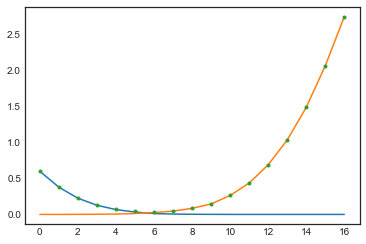

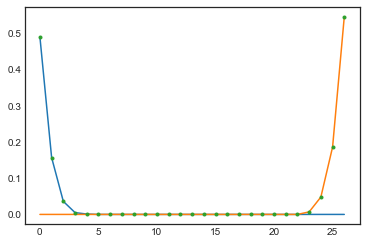

In [6]:
 t = 6
xBorrow,xReturn = pd.DataFrame(),pd.DataFrame()  
xBorrow['demand'],xReturn['demand'] = X_b_r(t,status_df,N)
index_id = list(status_df['station_id']).index('6450.05s')#5422.04
C = status_df['Capcity'][index_id ]
invo_expect_thwarted = expect_thwarted_df(C,list(xBorrow['demand'])[index_id],list(xReturn['demand'])[index_id])[1]
plt.plot(invo_expect_thwarted['thwarted_rent'])
plt.plot(invo_expect_thwarted['thwarted_return'])
plt.plot(invo_expect_thwarted['thwarted_demand'],'.')
print(invo_expect_thwarted['thwarted_demand'])

plt.figure(2)

index_id = list(status_df['station_id']).index('5400.05s')#6450.05
C = status_df['Capcity'][index_id ]
invo_expect_thwarted = expect_thwarted_df(C,list(xBorrow['demand'])[index_id],list(xReturn['demand'])[index_id])[1]
plt.plot(invo_expect_thwarted['thwarted_rent'])
plt.plot(invo_expect_thwarted['thwarted_return'])
plt.plot(invo_expect_thwarted['thwarted_demand'],'.')
print(invo_expect_thwarted['thwarted_demand'])

(array([ 51., 323., 751., 178., 108.,  50.,  23.,   9.,   3.,   2.]),
 array([ 0. ,  9.7, 19.4, 29.1, 38.8, 48.5, 58.2, 67.9, 77.6, 87.3, 97. ]),
 <BarContainer object of 10 artists>)

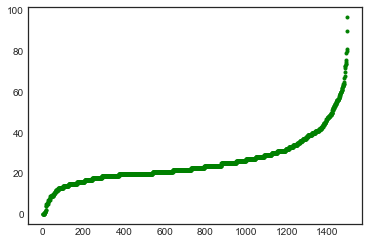

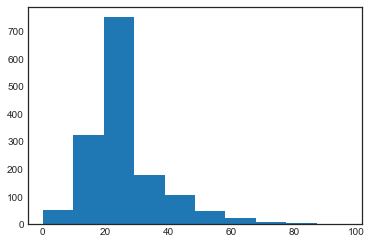

In [7]:
Safe_Count6 = Safe_Count6.sort_values()
plt.plot(list(Safe_Count6),'g.')
plt.figure(2)
plt.hist(list(Safe_Count6))

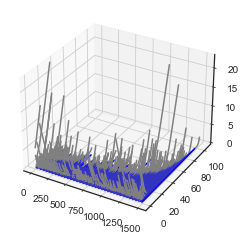

<Figure size 432x288 with 0 Axes>

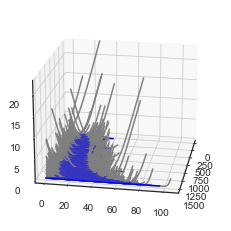

In [8]:
del dict_a_6['6407.07s'],dict_a_6['6602.03s'],Safe_Count6['6407.07s'],Safe_Count6['6602.03s']

station_order = Safe_Count6.keys()
fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.set_zlim(0,23) # Z轴范围
for i in range(len(dict_a_6.keys())):
    temp2 = dict_a_6[station_order[i]]
    z = list(temp2)
    z2 = list(temp2[temp2==0])
    x=[i for j in range(len(z))]
    x2 = x[:len(z2)]
    y = range(len(z))
    y2 = list(temp2[temp2==0].index)
    ax1.plot3D(x,y,z,'gray')
    ax1.plot3D(x2,y2,z2,'blue') 
plt.show()

plt.figure(2)

fig = plt.figure()
ax1 = plt.axes(projection='3d')
ax1.set_zlim(0, 23) # Z轴范围
for i in range(len(dict_a_6.keys())):
    temp2 = dict_a_6[station_order[i]]
    z = list(temp2)
    z2 = list(temp2[temp2==0])
    x=[i for j in range(len(z))]
    y = range(len(z))
    y2 = list(temp2[temp2==0].index)
    x2 = x[:len(z2)]
    ax1.plot3D(x,y,z,'gray')
    ax1.plot3D(x2,y2,z2,'blue') 
    ax1.view_init(20,10) 
plt.show()

In [9]:
dict_a_7,Safe_Count7 = duan(6,1,status_df,N)

*************   时段 6:00-7:00   *************
8.365÷2772=0.30176767676767674%
发生过失效的站点数：7
*************   时段 6:00-8:00   *************
69.03795499999998÷8673=0.796010088781275%
发生过失效的站点数：162


(array([409., 444., 474., 112.,  37.,  14.,   4.,   2.,   2.,   0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

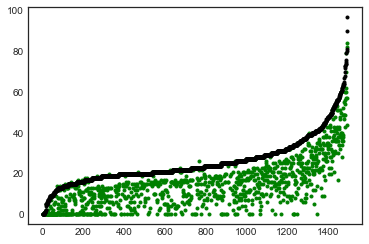

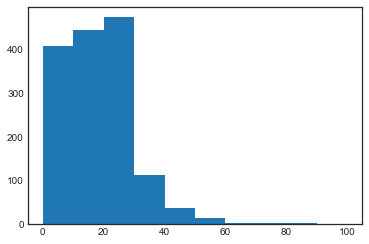

In [10]:
for i in range(len(station_order)):
    plt.plot(i,Safe_Count7[station_order[i]],'g.')
plt.plot(list(Safe_Count6),'k.')
plt.figure(3)
plt.hist(Safe_Count7,range=(0,100),bins = 10)

In [11]:
print('------------------------------   具体数值: 6点-7点    ------------------------------')
print(list(Safe_Count6))
print('------------------------------   具体数值: 6点-8点    ------------------------------')
for i in station_order:
    print(Safe_Count7[i])

------------------------------   具体数值: 6点-7点    ------------------------------
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 1

In [12]:
dict_a_8,Safe_Count8 = duan(6,2,status_df,N)

*************   时段 6:00-7:00   *************
8.517÷2772=0.3072510822510822%
发生过失效的站点数：8
*************   时段 6:00-8:00   *************
70.48072799999998÷8673=0.8126453130404703%
发生过失效的站点数：153
*************   时段 6:00-9:00   *************
176.78216015700002÷17172=1.0294791530223621%
发生过失效的站点数：524


(array([781., 342., 313.,  46.,  11.,   3.,   1.,   1.,   0.,   0.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

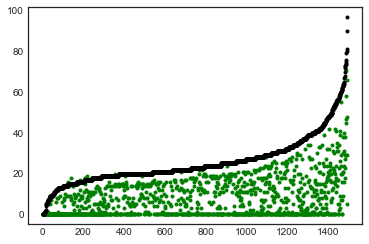

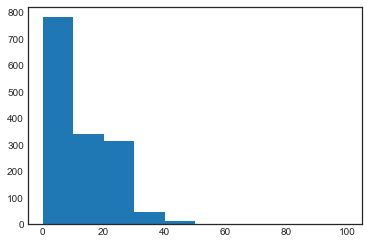

In [13]:
for i in range(len(station_order)):
    plt.plot(i,Safe_Count8[station_order[i]],'g.')
plt.plot(list(Safe_Count6),'k.')
plt.figure(3)
plt.hist(Safe_Count8,range=(0,100),bins = 10)

In [14]:
print('------------------------------   具体数值: 6点-9点    ------------------------------')
for i in station_order:
    print(Safe_Count8[i])

------------------------------   具体数值: 6点-9点    ------------------------------
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
5
0
7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
11
0
6
0
0
0
0
0
0
0
8
0
1
0
8
0
0
0
0
0
0
0
0
9
0
0
0
0
0
0
6
0
0
0
0
0
13
0
0
0
7
0
8
4
0
0
0
10
0
0
0
0
0
0
0
9
15
0
0
9
0
16
14
15
0
0
15
0
0
0
15
9
0
15
9
7
8
0
0
18
0
0
0
0
14
0
5
15
14
0
15
10
2
6
8
0
0
0
9
15
0
0
9
0
4
16
16
16
0
15
0
16
0
10
0
0
2
0
7
0
16
12
17
0
4
0
0
9
8
0
8
9
0
0
0
0
3
0
0
0
11
0
0
0
18
15
6
0
0
12
0
3
12
19
0
7
0
8
7
11
7
0
9
17
0
0
11
4
0
0
0
9
10
1
11
0
0
0
0
2
18
0
0
11
1
0
10
0
0
0
0
5
11
0
0
5
0
0
13
0
0
13
0
0
0
14
5
3
0
0
0
18
2
12
13
5
0
0
0
6
0
11
0
0
0
0
10
5
5
1
0
5
8
4
0
0
0
0
6
0
19
7
1
10
0
0
13
4
19
0
3
14
19
0
0
14
19
4
14
19
5
0
19
16
19
0
0
9
0
14
0
19
0
19
7
12
19
19
14
19
7
0
19
3
19
19
0
14
19
19
19
19
20
0
15
0
14
1
0
0
8
19
19
19
0
7
0
15
4
0
14
14
15
20
20
20
0
20
0
20
20
0
20
0
20
20
15
0
15
20
20
14
15
8
15
9
3
12
0
20
0
9
20
19
1

In [15]:
del dict_a_6,dict_a_7,dict_a_8,Safe_Count6,Safe_Count7,Safe_Count8

In [11]:
dict_all_day,Safe_Count_n = duan(6,17,status_df,N)

*************   时段 6:00-7:00   *************
8.644÷2772=0.31183261183261185%
发生过失效的站点数：9
*************   时段 6:00-8:00   *************
70.22010699999994÷8673=0.8096403435950644%
发生过失效的站点数：156
*************   时段 6:00-9:00   *************
175.23001314099972÷17172=1.020440328098065%
发生过失效的站点数：526
*************   时段 6:00-10:00   *************
266.4206422643743÷23520=1.1327408259539724%
发生过失效的站点数：742
*************   时段 6:00-11:00   *************
322.5742766560135÷28003=1.1519275672464147%
发生过失效的站点数：844
*************   时段 6:00-12:00   *************
364.518667573871÷32271=1.1295549179568996%
发生过失效的站点数：907
*************   时段 6:00-13:00   *************
409.0042901111615÷37284=1.096996808580521%
发生过失效的站点数：974
*************   时段 6:00-14:00   *************
460.6202418701704÷42696=1.078836991451589%
发生过失效的站点数：1027
*************   时段 6:00-15:00   *************
520.353711410937÷48676=1.069014938390453%
发生过失效的站点数：1098
*************   时段 6:00-16:00   *************
615.0964396050022÷55908=1.1001939608016

In [12]:
# 如果要 服务水平 99%
duan1,Safe_Count_n = duan(6,1,status_df,N)

*************   时段 6:00-7:00   *************
8.568000000000001÷2772=0.30909090909090914%
发生过失效的站点数：6
*************   时段 6:00-8:00   *************
70.618583÷8673=0.814234786117837%
发生过失效的站点数：149


In [32]:
duan2,Safe_Count_n = duan(8,8,status_df,N)

*************   时段 8:00-9:00   *************
18.806000000000004÷8499=0.22127309095187675%
发生过失效的站点数：33
*************   时段 8:00-10:00   *************
74.64756999999993÷14847=0.5027788105341142%
发生过失效的站点数：358
*************   时段 8:00-11:00   *************
108.48089879700011÷19330=0.5612048566839116%
发生过失效的站点数：611
*************   时段 8:00-12:00   *************
130.35804212440786÷23598=0.5524113997983213%
发生过失效的站点数：745
*************   时段 8:00-13:00   *************
154.50428997936797÷28611=0.5400170912563977%
发生过失效的站点数：855
*************   时段 8:00-14:00   *************
188.5596695276429÷34023=0.5542123549588305%
发生过失效的站点数：940
*************   时段 8:00-15:00   *************
231.60607351656336÷40003=0.5789717609093402%
发生过失效的站点数：1026
*************   时段 8:00-16:00   *************
308.468571047229÷47235=0.6530508543394283%
发生过失效的站点数：1087
*************   时段 8:00-17:00   *************
462.3659872608286÷55305=0.8360292690730107%
发生过失效的站点数：1137


In [14]:
duan3,Safe_Count_n = duan(17,6,status_df,N)

*************   时段 17:00-18:00   *************
16.584000000000003÷9832=0.1686737184703011%
发生过失效的站点数：56
*************   时段 17:00-19:00   *************
71.97634299999991÷19196=0.37495490206292936%
发生过失效的站点数：515
*************   时段 17:00-20:00   *************
134.7225998069998÷26111=0.5159610884569714%
发生过失效的站点数：782
*************   时段 17:00-21:00   *************
184.15042868926807÷30415=0.6054592427725402%
发生过失效的站点数：879
*************   时段 17:00-22:00   *************
213.9288503788818÷33249=0.6434143895421872%
发生过失效的站点数：922
*************   时段 17:00-23:00   *************
242.62686485015183÷35375=0.6858709960428321%
发生过失效的站点数：957
*************   时段 17:00-24:00   *************
266.4132466144464÷36725=0.7254274924831761%
发生过失效的站点数：994


In [34]:
(70.619+462.365+266.413)/(8673+55305+36725)

0.007938164702143929

In [28]:
'''
# 存入 静态调度的 投放-需求损失 对应关系F(x)，用于调度分区
pd.DataFrame(dict_all_day).to_csv('C:/Users/83621/citibike2/FX_all_day.csv')

In [29]:
# 输出上下界
def range_invo(duan_):
    Upp_v_6 = 0
    Low_v_6 = 0
    for station_id in duan_.keys():
        min_v = min(duan_[station_id])
        temp = duan_[station_id][duan_[station_id]==min_v].index
        low_v = temp[0]
        upp_v = temp[-1]
        Upp_v_6 += upp_v
        Low_v_6 += low_v
    print(['下界： ',Low_v_6,'  上界： ',Upp_v_6])

In [37]:
# 表4-2
range_invo(duan1)
range_invo(duan2)
range_invo(duan3)
range_invo(dict_all_day)

['下界： ', 11500, '  上界： ', 35757]
['下界： ', 20655, '  上界： ', 25084]
['下界： ', 18185, '  上界： ', 25062]
['下界： ', 21683, '  上界： ', 23948]
